# Team MRAI

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt


sns.set_theme('notebook', 'whitegrid', 'Set1')

In [2]:
df = pd.read_csv('../dataset/Padrão Urbano/PU.csv', sep=';')

#df = df.drop('SETTT', axis=1)
df.head(5)

,SETTT,VIAGEM,TDESL,HOMIC,ARISC,PMANC,EXURB,POP80,POP81,POP82,...,LIX10,PJM80,PJM91,PJM00,PJM10,VER80,VER91,VER00,VER10,CLUSTER
0,355030801000001,1428.9,29.8,1,0,0,2,1050,1043,1035,...,0.9962,0.0810,0.0759,0.0658,0.0558,0.0407,0.0215,0.0260,0.0410,C
1,355030801000002,1554.2,21.7,1,0,0,1,1091,1079,1068,...,1.0000,0.1006,0.0802,0.0818,0.0701,0.4207,0.0000,0.0068,0.0000,A
2,355030801000003,1471.5,25.8,1,0,0,2,963,960,956,...,1.0000,0.0935,0.0863,0.0840,0.0560,0.0433,0.0000,0.0531,0.0370,C
3,355030801000004,1404.8,27.7,2,0,0,2,1218,1183,1149,...,1.0000,0.0904,0.0745,0.0658,0.0752,0.4054,0.1043,0.1602,0.1271,B
4,355030801000005,1492.0,28.6,2,0,0,2,1201,1181,1163,...,1.0000,0.0954,0.0863,0.1101,0.0809,0.5530,0.0000,0.0575,0.0500,B


In [3]:
selected_columns = set(''.join([i for i in column if not i.isdigit()]) for column in df.columns)
selected_columns = [f"{column}10"if len(column) == 3 else column for column in selected_columns]

df = df[selected_columns]

In [4]:
crimes = pd.read_csv('../dataset/Crimes/Listagem_Geral.csv', index_col=0)

counts = crimes['SETOR'].value_counts()

y_crimes = df['SETTT'].apply(lambda setor : counts.get(setor, 0))

In [5]:
# One hot encoding
categorical_columns = [column for column in selected_columns if column in ['HOMIC', 'ARISC', 'PMANC', 'EXURB', 'AGL91', 'AGL00', 'AGL10', 'DEN80', 'DEN91', 'DEN00', 'DEN10', 'CLUSTER']]

# one hot enconding apenas nas colunas categóricas, precisa setar o 'sparse_output' para False para ter a saida como um dataframe e conseguir concatenar com o restante dos dados
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas').fit(df[categorical_columns])

#enc.categories_
data_ohe = enc.transform(df[categorical_columns])

data_drop = df.drop(categorical_columns, axis=1)

data = pd.concat([data_drop, data_ohe], axis=1)
data.head(5)

,DPP10,AGU10,POP10,CMU10,SETTT,CAR10,VIAGEM,LIX10,ESG10,VER10,...,HOMIC_3,HOMIC_4,PMANC_0,PMANC_1,AGL10_0,AGL10_1,DEN10_1,DEN10_2,DEN10_3,DEN10_4
0,0.9925,1.0,806,0.3619,355030801000001,0.0224,1428.9,0.9962,1.0,0.0410,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0000,1.0,913,0.3268,355030801000002,0.0163,1554.2,1.0000,1.0,0.0000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0000,1.0,625,0.4392,355030801000003,0.0106,1471.5,1.0000,1.0,0.0370,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0000,1.0,572,0.5414,355030801000004,0.0055,1404.8,1.0000,1.0,0.1271,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0000,1.0,754,0.4458,355030801000005,0.0000,1492.0,1.0000,1.0,0.0500,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [6]:
# Separação dos dados
my_seed = 42
X = data

# Dividindo o dataset em conjunto de treino, validação e teste
X_train, X_test, y_train_crimes, y_test_crimes = train_test_split(X.drop(columns=['SETTT']), y_crimes, test_size=0.2, random_state=my_seed)

# Holdout (Realizamos Validação cruzada)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=my_seed)

In [7]:
# Preparar os dados para serem usados nos algoritmos
crime_threshold = 300

y_train = np.where(y_train_crimes >= 300, 1, 0)
y_test  = np.where(y_test_crimes >= 300, 1, 0)

---

## Modelos

In [8]:
n_trials = 100

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import get_scorer
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

class Optuner:
    def __init__(self, model, X, y, scoring='accuracy', parameters=None, n_splits=5, n_repeats=1, seed=None):
        self.model = model
        self.scoring = scoring
        
        self.cross = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        self.parameters = parameters if parameters is not None else {}

        self.study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))

        self.X = X
        self.y = y


    def add_parameter(self, name, type, **config):
        assert name in self.model.get_params()

        self.parameters[name] = {'type' : type, **config}

    def fix_parameter(self, name, value):
        self.add_parameter(name, 'fixed', value=value)

    def add_categorical(self, name, choices):
        self.add_parameter(name, 'categorical', choices=choices)

    def add_int(self, name, low, high, step=1, log=False):
        self.add_parameter(name, int, low=low, high=high, step=step, log=log)

    def add_float(self, name, low, high, step=None, log=False):
        self.add_parameter(name, float, low=low, high=high, step=step, log=log)


    def fit(self, model, X, y):
        model.fit(X, y)
        return model


    def trial(self, trial : optuna.trial.Trial):
        params = {}

        for parameter, config in self.parameters.items():
            config = config.copy()

            param_type = config.pop('type')


            if param_type == 'categorical':
                suggestion = trial.suggest_categorical

            elif param_type == 'float' or param_type is float:
                suggestion = trial.suggest_float

            elif param_type == 'int' or param_type is int:
                suggestion = trial.suggest_int

            elif param_type == 'fixed':
                suggestion = trial.suggest_categorical
                config = {'choices' : [config['value']]}

            params[parameter] = suggestion(parameter, **config)

        model = self.model.set_params(**params)

        scores = []

        for train_idx, val_idx in self.cross.split(self.X, self.y):
            try:
                self.fit(model, self.X.iloc[train_idx], self.y[train_idx])
            
            except Exception as e:
                score = np.nan
                print(e)
            else:
                score = get_scorer(self.scoring)(model, self.X.iloc[val_idx], self.y[val_idx])

            scores.append(score)

        return np.nanmean(score)

    def optimize(self, n_trials):
        self.study.optimize(self.trial, n_trials=n_trials,  show_progress_bar=True)

    @property
    def best_params(self): return self.study.best_params

    @property
    def best_model(self): return self.model.set_params(**self.best_params)

    def get_dataframe(self): return self.study.trials_dataframe()

### Risk minimization methods

#### Logistic Regression

In [10]:
baseline_logistic = Pipeline([('transform', MinMaxScaler()), ('model', LogisticRegression())])

baseline_logistic_tuner = Optuner(baseline_logistic, X_train, y_train, scoring="balanced_accuracy", seed=42)

baseline_logistic_tuner.add_parameter('model__penalty', 'categorical', choices=['l1', 'l2'])
baseline_logistic_tuner.add_parameter('model__C', float, low=1e-5, high=1e4, log=True)
baseline_logistic_tuner.fix_parameter('model__solver', 'liblinear')

baseline_logistic_tuner.optimize(n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

#### XGBoost

In [11]:
baseline_xgb_tuner = Optuner(XGBClassifier(), X_train, y_train, scoring="balanced_accuracy", seed=42)

baseline_xgb_tuner.add_categorical('max_depth', [2, 4, 5, 6, 8])
baseline_xgb_tuner.add_float('learning_rate', low=1e-2, high=1e-1, log=True)
baseline_xgb_tuner.add_int('n_estimators', low=50, high=200)
baseline_xgb_tuner.add_float('subsample', low=0.5, high=1)

baseline_xgb_tuner.optimize(n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

---
### Model analysis

In [12]:
from sklearn.metrics import pairwise_distances, recall_score

def consistency_score(estimator, X, y, k_neigh=5, metric="euclidean"):
    distances = pairwise_distances(X, metric=metric)

    y_pred = estimator.predict(X)

    y_neigh = y_pred[np.argsort(distances, axis=1)[:, 1:k_neigh+1]].mean(axis=1)

    return 1 - np.abs(y - y_neigh).mean()


def AOD(estimator, X, y, sensitive_feature, cut=0.07):
    y_pred = estimator.predict(X)

    priv   = X[sensitive_feature] >= cut
    unpriv = X[sensitive_feature] <  cut
    

    unpriv_recall = recall_score(y[unpriv], y_pred[unpriv], zero_division=0)

    priv_recall   = recall_score(y[priv], y_pred[priv], zero_division=0)

    unpriv_fpr    = recall_score(1-y[unpriv], y_pred[unpriv], zero_division=0)

    priv_fpr      = recall_score(1-y[priv], y_pred[priv], zero_division=0)

    return 0.5*(unpriv_recall - priv_recall) + 0.5*(unpriv_fpr - priv_fpr)

In [13]:
def style(df, format_table):
    return df.style.highlight_max().format(format_table,)

def evaluate(models, X, y, X_test, y_test, fit_function=None, metrics=None, cv=25, df=None, configs=None, figname=None):
    if fit_function is None:
        fit_function = lambda model, X, y : model.fit(X, y)


    if configs is None:
        configs = {}

    if df is None:
        n_configs = len(configs)
        index = pd.MultiIndex(levels=[[] for _ in range(n_configs + 1)], codes=[[] for _ in range(n_configs + 1)], names=[u'Model'] + list(configs.keys()))
        df = pd.DataFrame(index=index, columns=metrics.keys())

    for config, value in configs.items():
        if not isinstance(value, str) and hasattr(value, '__len__'):
            assert len(value) == len(models)
        
        else:
            configs[config] = [value] * len(models)

    # Cross-validation
    results = {}
    for i, (name, model) in enumerate(models.items()):
        scores = {metric : [] for metric in metrics}
        for train_idx, val_idx in RepeatedStratifiedKFold(n_splits=cv, n_repeats=1).split(X, y):
            fit_function(model, X.iloc[train_idx], y[train_idx])

            for metric_name, metric in metrics.items():
                scores[metric_name].append(metric(model, X.iloc[val_idx], y[val_idx]))

        results[name] = scores

        # Test results
        fit_function(model, X, y)

        result = {metric : scorer(model, X_test, y_test) for metric, scorer in metrics.items()}
        config = map(lambda x : x[i], configs.values())

        df.loc[(name, *config), :] = result


    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title('Algorithm Comparison')

    n_metrics = len(metrics)
    n_models  = len(models)

    names = list(models.keys())

    spacing = 0.1
    delta   = (1 - spacing)*(1 - 1/n_metrics)/2

    positions = np.hstack([np.linspace(i - delta, i + delta, n_metrics) for i in range(n_models)])
    boxes = plt.boxplot(np.array([model_result[metric] for model_result in results.values() for metric in metrics]).T, positions=positions, widths=1.5*delta/(n_metrics-1), patch_artist=True)

    ax.xaxis.set_major_formatter(lambda _, i : names[i//n_metrics] if i%n_metrics==1 else '')

    for i in range(n_metrics * n_models):
        color = sns.color_palette(n_colors=n_metrics)[i%n_metrics]

        boxes['boxes'][i].set_color((1, 1, 1, 0.4))
        boxes['boxes'][i].set(facecolor=color, alpha=0.8)
        boxes['medians'][i].set_color((0, 0, 0, 0.4))
        boxes['whiskers'][2*i].set_color(color)
        boxes['whiskers'][2*i+1].set_color(color)
        boxes['caps'][2*i].set_color(color)
        boxes['caps'][2*i+1].set_color(color)
        boxes['fliers'][i].set_color(color)
        boxes['fliers'][i].set_color(color)

    for i, metric in enumerate(metrics):
        boxes['boxes'][i].set_label(metric)

    plt.ylim((0, 1))
    plt.ylabel("Score")
    plt.legend(frameon=True, bbox_to_anchor=(1.1, 1.05))

    if figname is not None:
        plt.savefig(f"{figname}.png")

    plt.show()

    return df

In [14]:
from sklearn.metrics import get_scorer, brier_score_loss, make_scorer

metrics = {"Bal Acc"      : get_scorer("balanced_accuracy"),
           "ROC AUC"      : get_scorer("roc_auc"),
           "Brier Loss"   : make_scorer(brier_score_loss, needs_proba=True),
           "Consistency"  : consistency_score,
           "Average odds" : lambda model, X, y : AOD(model, X, y, sensitive_feature="CAR10")}

format_table = {"Bal Acc" : "{:.1%}",
                "ROC AUC" : "{:.3f}",
                "Brier Loss" : "{:.3f}",
                "Consistency" : "{:.3f}",
                "Average odds" : "{:.3f}"}

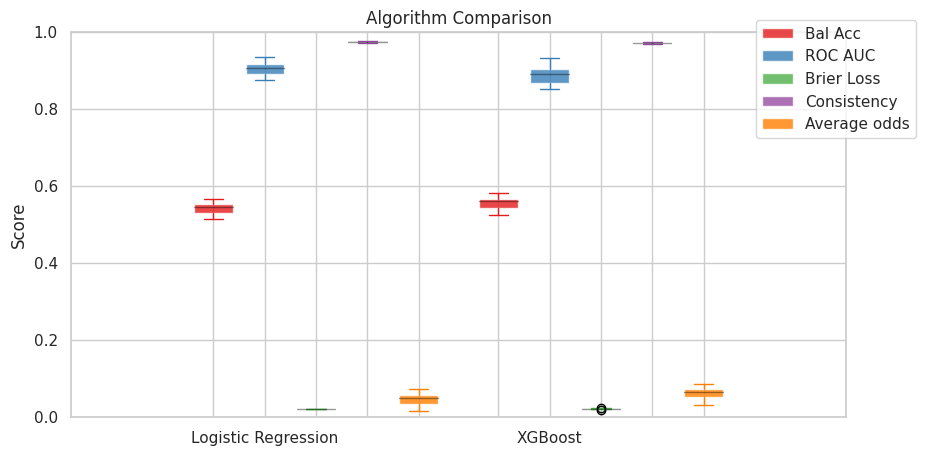

,,Bal Acc,ROC AUC,Brier Loss,Consistency,Average odds
Model,Fairness method,,,,,
Logistic Regression,None,52.5%,0.920,0.020,0.973,0.028
XGBoost,None,54.0%,0.915,0.021,0.970,0.049


In [15]:
baseline_models = {
    "Logistic Regression" : baseline_logistic_tuner.best_model,
    "XGBoost"             : baseline_xgb_tuner.best_model
}

results = evaluate(baseline_models, X_train, y_train, X_test, y_test, metrics=metrics, cv=10, configs={"Fairness method" : "None"}, figname="No Fairness comparison")
style(results, format_table)

---
## Fairness

For this work, we are going to measure the fairness of the model by two main metrics: 

- Consistency, defined before
- Average odds

The objective is to ensure nearby samples receive the same treatment as the target one while we still make sure regions are not priorized by different income ratios.

In [16]:
def round_down(n):
    if n == 0: return 0

    base = 10**np.floor(np.log10(np.abs(n)))
    return np.floor(n / base) * base

def round_up(n):
    if n == 0: return 0
    
    base = 10**np.floor(np.log10(np.abs(n)))
    return np.ceil(n / base) * base

def align_axes(main_ax:plt.Axes, twin_ax:plt.Axes, new_ticks=None):
    l, u = main_ax.get_ylim()
    ticks = main_ax.get_yticks()
    ticks = ticks[(ticks >= l) & (ticks <= u)]

    ticks_given = False
    if new_ticks is None:
        lower, upper = twin_ax.get_ylim()

        max_delta = (upper - lower)/(len(ticks) - 1)

        delta     = round_up(max_delta)

        tick_min  = round_down(lower)

        tick_max  = tick_min + delta * (len(ticks) - 1)

    elif len(new_ticks) == 2:
        tick_min, tick_max = new_ticks

    elif len(new_ticks) == len(ticks): 
        tick_min, tick_max = new_ticks[0], new_ticks[-1]
        ticks_given = True

        if not isinstance(new_ticks, np.ndarray):
            new_ticks = np.array(new_ticks)
    else:
        raise TypeError("Length of the target ticks do not match with the ticks on main axes.")

    bminusa = (tick_max - tick_min) * (u - l)/(ticks[-1] - ticks[0])

    a = tick_max - (ticks[-1] - l)/(u - l) * bminusa
    b = bminusa + a

    if not ticks_given:
        new_ticks = np.linspace(tick_min, tick_max, len(ticks))

    twin_ax.set_yticks(new_ticks)
    twin_ax.set_ylim(a, b)

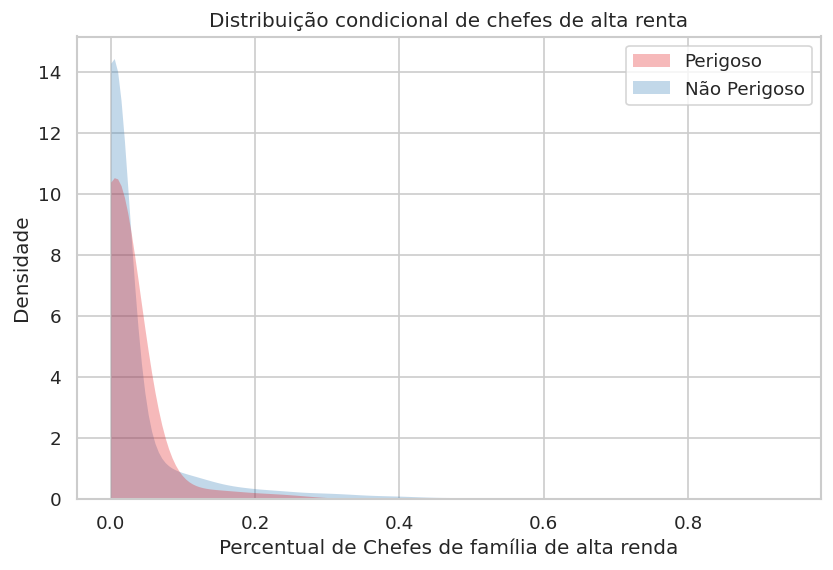

In [17]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

sns.kdeplot(X_train, x="CAR10", hue=np.where(y_train, "Perigoso", "Não Perigoso"), hue_order= ["Perigoso", "Não Perigoso"],
             common_norm=False, common_grid=True, cut=0, bw_adjust=2, fill=True, alpha=.3, linewidth=0, ax=ax)

ax.set_title("Distribuição condicional de chefes de alta renta")
ax.set_xlabel("Percentual de Chefes de família de alta renda")
ax.set_ylabel("Densidade")
plt.savefig("Sentitive distribution.png")
plt.show()

In [50]:
def plot_sensitive(models, X, y, sensitive_feature, X_predict=None, n=100, figname=None):
    if X_predict is None:
        X_predict = X

    fig, axs = plt.subplots(ncols=len(models),figsize=(8*len(models), 5), dpi=120)

    axs = np.atleast_1d(axs)

    for i, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_predict)

        sns.kdeplot(X, x=sensitive_feature, hue=np.where(y_pred == 1, "Perigoso", "Não Perigoso"), hue_order= ["Perigoso", "Não Perigoso"],
                    common_norm=False, common_grid=True, cut=0, bw_adjust=2, fill=True, alpha=.3, linewidth=0., ax=axs[i])

        ax = axs[i].twinx()

        cuts = np.linspace(0, 1, n)

        aod = np.array([AOD(model, X_predict, y, sensitive_feature, cut=cut) for cut in cuts])

        max_aod = aod.max() if aod.max() != 0 else 1.
        norm_aod = (aod + aod.max())/max_aod

        ax.scatter(cuts, aod, alpha=1, s=7, c=plt.get_cmap('RdYlBu')((norm_aod - 0.5)*8 + 0.5)[:, :3], label="Average odds")
        align_axes(axs[i], ax)
        axs[i].set_title(name)
        axs[i].set_xlabel("Percentual de Chefes de família de alta renda")
        axs[i].set_ylabel("Densidade")
        ax.set_ylabel("Average Odds Difference")
        sns.move_legend(axs[i], loc='lower right')

    fig.tight_layout()

    if figname is not None:
        plt.savefig(f"{figname}.png")

    plt.show()

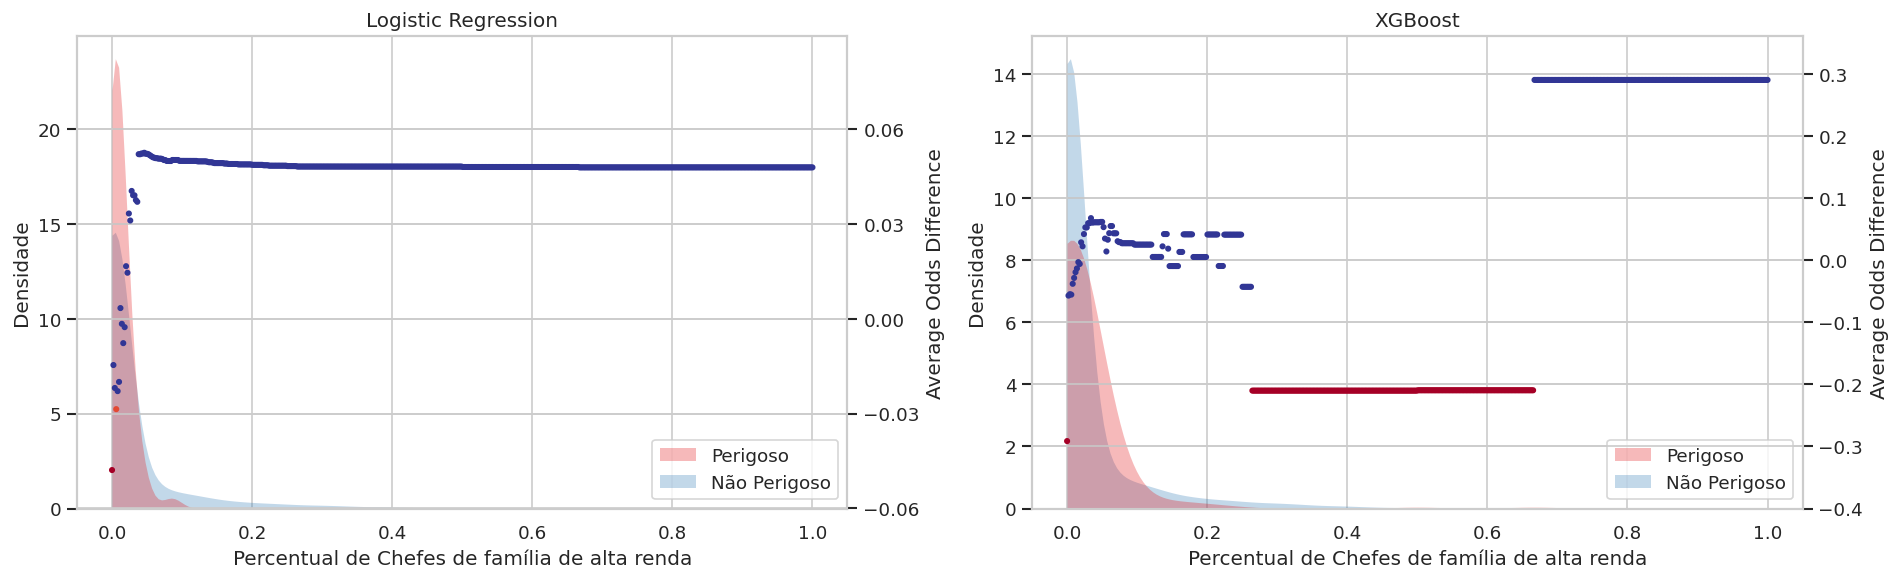

In [19]:
plot_sensitive(baseline_models, X_train, y_train, "CAR10", n=500, figname="No Fairness sensitive")

### Preprocessing Methods

#### Data augmentation

In [20]:
frac = 0.5

n_aug_samples = int(len(X_train) * frac)

idx = np.random.randint(0, len(X_train), size=n_aug_samples)

X_aug = X_train.iloc[idx].copy()

X_aug["CAR10"] = X_train["CAR10"].sample(n=n_aug_samples, replace=True, random_state=21).to_numpy()

y_aug = y_train[idx]

X_aug = pd.concat([X_train, X_aug])
y_aug = np.hstack([y_train, y_aug])

In [21]:
logistic_pipeline = Pipeline([('transform', MinMaxScaler()), ('model', LogisticRegression())])

augmented_logistic_tuner = Optuner(logistic_pipeline, X_aug, y_aug, scoring="balanced_accuracy", seed=42)

augmented_logistic_tuner.add_parameter('model__penalty', 'categorical', choices=['l1', 'l2'])
augmented_logistic_tuner.add_parameter('model__C', float, low=1e-5, high=1e4, log=True)
augmented_logistic_tuner.fix_parameter('model__solver', 'liblinear')

augmented_logistic_tuner.optimize(n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
augmented_xgb_tuner = Optuner(XGBClassifier(), X_aug, y_aug, scoring="balanced_accuracy", seed=42)

augmented_xgb_tuner.add_categorical('max_depth', [2, 4, 5, 6, 8])
augmented_xgb_tuner.add_float('learning_rate', low=1e-2, high=1e-1, log=True)
augmented_xgb_tuner.add_int('n_estimators', low=50, high=200)
augmented_xgb_tuner.add_float('subsample', low=0.5, high=1)

augmented_xgb_tuner.optimize(n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

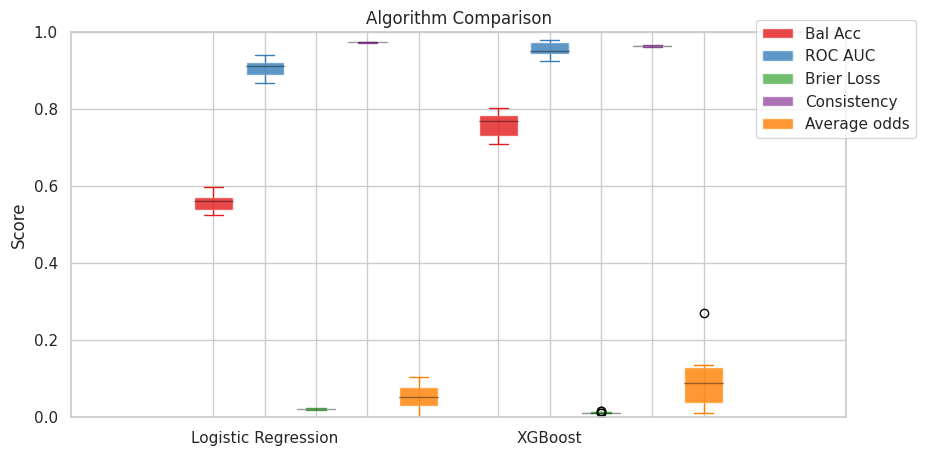

,,Bal Acc,ROC AUC,Brier Loss,Consistency,Average odds
Model,Fairness method,,,,,
Logistic Regression,None,52.5%,0.920,0.020,0.973,0.028
XGBoost,None,54.0%,0.915,0.021,0.970,0.049
Logistic Regression,Data Augmentation,55.1%,0.920,0.020,0.971,0.058
XGBoost,Data Augmentation,54.2%,0.916,0.022,0.973,0.048


In [23]:
augmented_models = {
    "Logistic Regression" : augmented_logistic_tuner.best_model,
    "XGBoost"             : augmented_xgb_tuner.best_model
}

results = evaluate(augmented_models, X_aug, y_aug, X_test, y_test, metrics=metrics, cv=10, df=results, configs={"Fairness method" : "Data Augmentation"}, figname="Data augmentation comparison")
style(results, format_table)

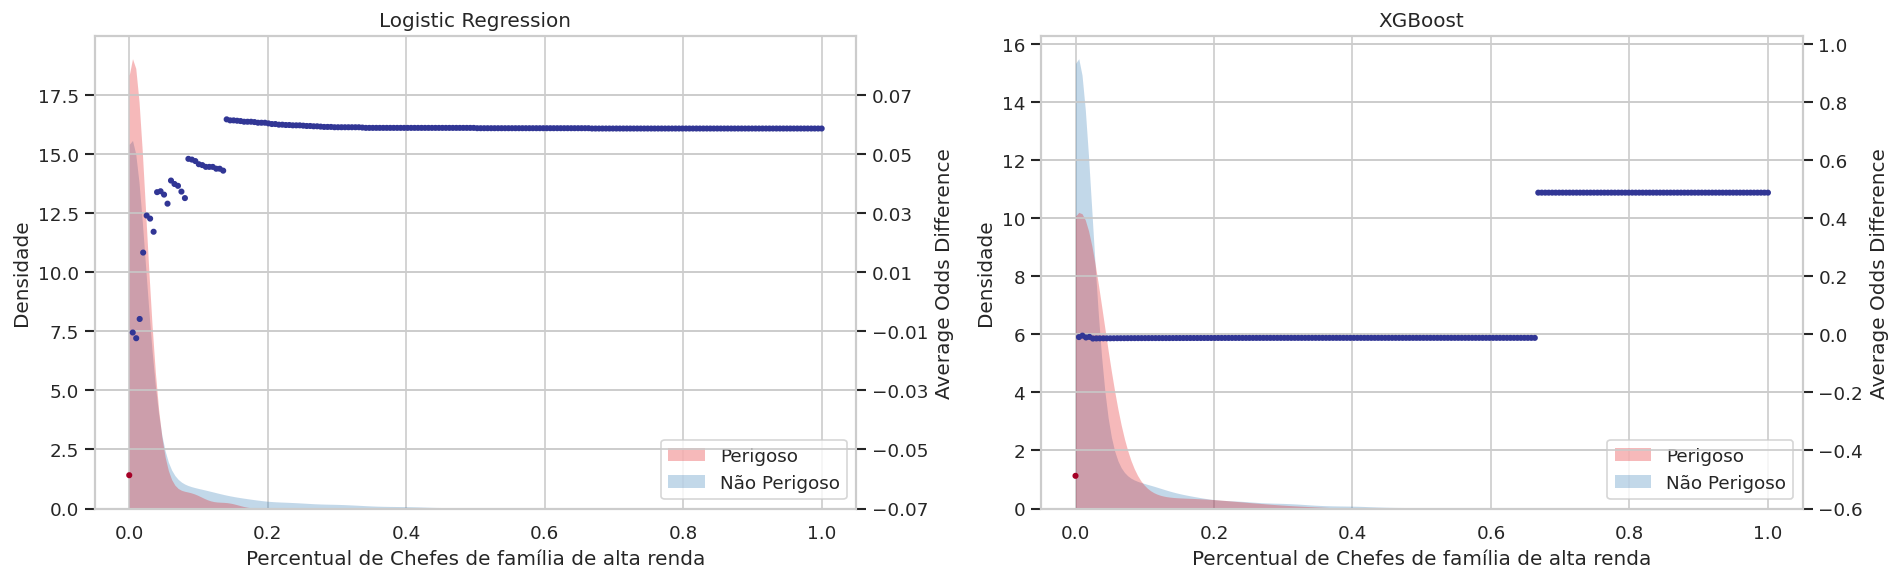

In [24]:
plot_sensitive(augmented_models, X_aug, y_aug, "CAR10", n=200, figname="Data augmentation sensitive")

#### Learning Fair representations

In [25]:
from aif360.sklearn.preprocessing import LearnedFairRepresentations

In [26]:
preprocessing = Pipeline([
    ('zscore', StandardScaler().set_output(transform='pandas')),
    ("preprocessing", LearnedFairRepresentations(max_iter=500)), 
    ('last', StandardScaler().set_output(transform='pandas'))
])

In [27]:
X_fair = preprocessing.fit_transform(X_train, y_train)
X_fair_test = preprocessing.transform(X_test)

In [28]:
logistic_tuner = Optuner(LogisticRegression(), X_fair, y_train, scoring="balanced_accuracy", seed=42)

logistic_tuner.add_parameter('C', float, low=1e-5, high=1e4, log=True)
logistic_tuner.fix_parameter('solver', 'liblinear')


logistic_tuner.optimize(n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
xgb_tuner = Optuner(XGBClassifier(), X_fair, y_train, scoring="balanced_accuracy", seed=42)

xgb_tuner.add_categorical('max_depth', [2, 4, 5, 6, 8])
xgb_tuner.add_float('learning_rate', low=1e-2, high=1e-1, log=True)
xgb_tuner.add_int('n_estimators', low=50, high=200)
xgb_tuner.add_float('subsample', low=0.5, high=1)

xgb_tuner.optimize(n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

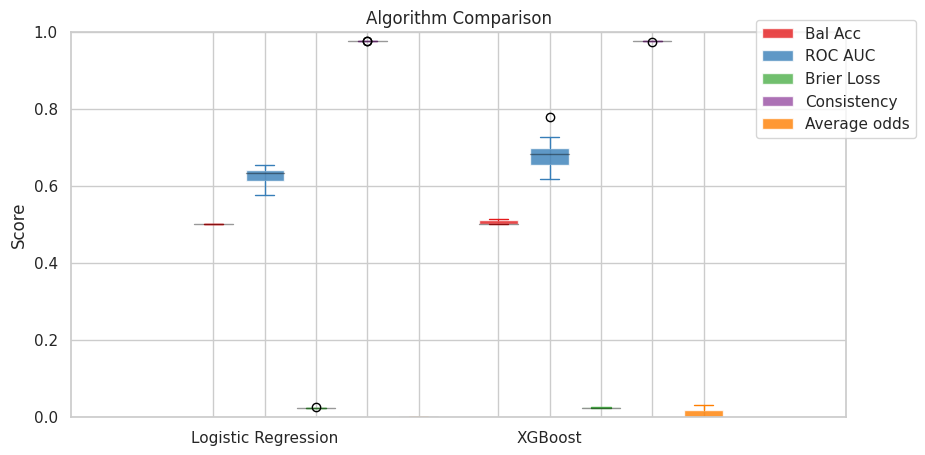

,,Bal Acc,ROC AUC,Brier Loss,Consistency,Average odds
Model,Fairness method,,,,,
Logistic Regression,None,52.5%,0.920,0.020,0.973,0.028
XGBoost,None,54.0%,0.915,0.021,0.970,0.049
Logistic Regression,Data Augmentation,55.1%,0.920,0.020,0.971,0.058
XGBoost,Data Augmentation,54.2%,0.916,0.022,0.973,0.048
Logistic Regression,Fair representations,50.0%,0.608,0.024,0.975,0.000
XGBoost,Fair representations,50.5%,0.723,0.024,0.975,0.011


In [30]:
fair_models = {
    "Logistic Regression" : logistic_tuner.best_model,
    "XGBoost"             : xgb_tuner.best_model
}

results = evaluate(fair_models, X_fair, y_train, X_fair_test, y_test, metrics=metrics, cv=10, df=results, configs={"Fairness method" : "Fair representations"}, figname="Fair representations comparison")
style(results, format_table)

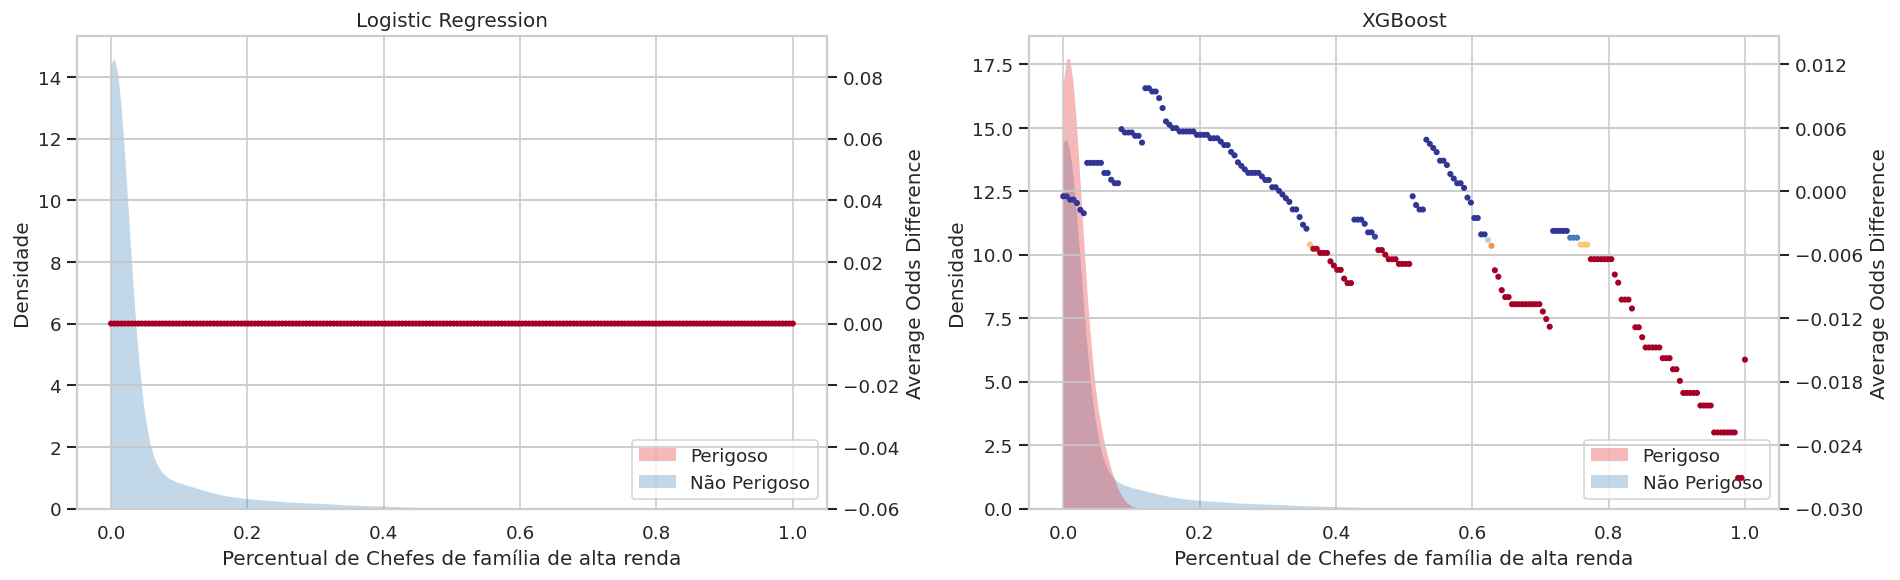

In [31]:
plot_sensitive(fair_models, X_train, y_train, "CAR10", X_predict=X_fair, n=200, figname="Fair representations sensitive")

### In-processing Methods

#### Equal Opportunity Optimization

In [32]:
from sklego.linear_model import EqualOpportunityClassifier
import warnings

warnings.filterwarnings("ignore")

In [33]:
equal_model = EqualOpportunityClassifier(sensitive_cols="CAR10", covariance_threshold=0.1, positive_target=True)

In [34]:
equal_pipeline = Pipeline([('zscore', StandardScaler().set_output(transform='pandas')), ("model", equal_model)])

equal_tuner = Optuner(equal_pipeline, X_train, y_train, scoring="balanced_accuracy", seed=42)

equal_tuner.add_float('model__estimator__C', 1e-5, 1e4, log=True)
equal_tuner.add_float('model__estimator__covariance_threshold', 1e-3, 1., log=True)

equal_tuner.optimize(n_trials//10)

  0%|          | 0/10 [00:00<?, ?it/s]

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


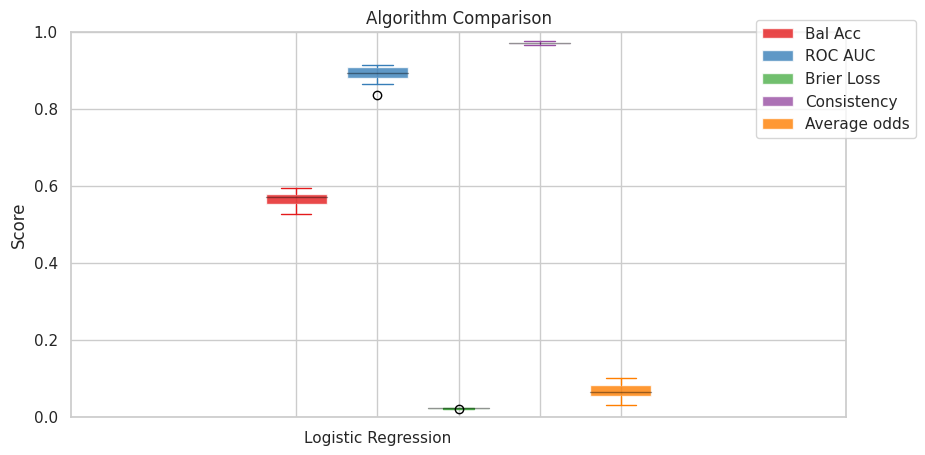

,,Bal Acc,ROC AUC,Brier Loss,Consistency,Average odds
Model,Fairness method,,,,,
Logistic Regression,None,52.5%,0.920,0.020,0.973,0.028
XGBoost,None,54.0%,0.915,0.021,0.970,0.049
Logistic Regression,Data Augmentation,55.1%,0.920,0.020,0.971,0.058
XGBoost,Data Augmentation,54.2%,0.916,0.022,0.973,0.048
Logistic Regression,Fair representations,50.0%,0.608,0.024,0.975,0.000
XGBoost,Fair representations,50.5%,0.723,0.024,0.975,0.011
Logistic Regression,Equal Opportunity,57.7%,0.890,0.022,0.970,0.087


In [36]:
equal_models = {
    "Logistic Regression" : equal_tuner.best_model,
}

results = evaluate(equal_models, X_train, y_train, X_test, y_test, metrics=metrics, cv=10, df=results, configs={"Fairness method" : "Equal Opportunity"}, figname="Equal opportunity comparison")
style(results, format_table)

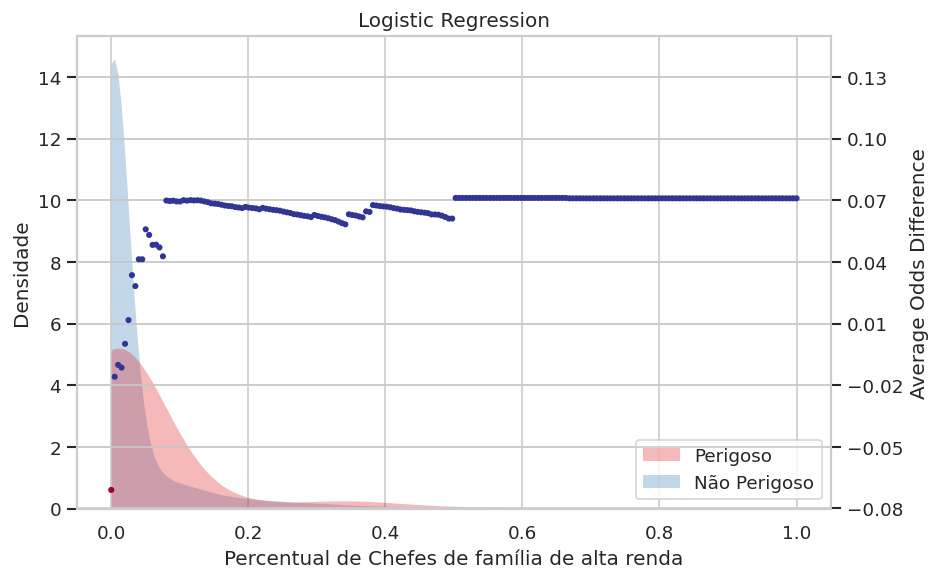

In [45]:
plot_sensitive(equal_models, X_train, y_train, "CAR10", n=200, figname="Equal opportunity sensitive")

### Post-processing Methods

#### Threshold Optimizer

In [37]:
from fairlearn.postprocessing import ThresholdOptimizer

pipeline = Pipeline([("preprocess", MinMaxScaler()), ("model", LogisticRegression())])

threshold_model = ThresholdOptimizer(estimator   = pipeline,
                                    constraints = "equalized_odds",
                                    objective="balanced_accuracy_score",
                                    predict_method='auto')

threshold_model.predict_ = threshold_model.predict
threshold_model.predict  = lambda X : threshold_model.predict_(X, sensitive_features=X["CAR10"])

threshold_model.fit_ = threshold_model.fit
threshold_model.fit  = lambda X, y : threshold_model.fit_(X, y, sensitive_features=X["CAR10"]>=0.07)

threshold_tuner = Optuner(threshold_model, X_train, y_train, scoring="balanced_accuracy", seed=42)

threshold_tuner.add_parameter('estimator__model__penalty', 'categorical', choices=['l1', 'l2'])
threshold_tuner.add_parameter('estimator__model__C', float, low=1e-5, high=1e4, log=True)
threshold_tuner.fix_parameter('estimator__model__solver', 'liblinear')

threshold_tuner.optimize(n_trials)

threshold_model.predict_proba = threshold_model.estimator_.predict_proba
threshold_model.decision_function = lambda x: threshold_model.estimator_.predict_proba(x)[:, 1]

threshold_model._estimator_type = "classifier"
threshold_model.classes_ = np.array([0,1])

  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
xgb_model = XGBClassifier()

xgb_threshold_model = ThresholdOptimizer(estimator   = xgb_model,
                                    constraints = "equalized_odds",
                                    objective="balanced_accuracy_score",
                                    predict_method="auto")

xgb_threshold_model.predict_ = xgb_threshold_model.predict
xgb_threshold_model.predict  = lambda X : xgb_threshold_model.predict_(X, sensitive_features = X["CAR10"])

xgb_threshold_model.fit_ = xgb_threshold_model.fit
xgb_threshold_model.fit  = lambda X, y : xgb_threshold_model.fit_(X, y, sensitive_features=X["CAR10"]>=0.07)

xgb_threshold_tuner = Optuner(xgb_threshold_model, X_train, y_train, scoring="balanced_accuracy", seed=42)

xgb_threshold_tuner.add_categorical('estimator__max_depth', [2, 4, 5, 6, 8])
xgb_threshold_tuner.add_float('estimator__learning_rate', low=1e-2, high=1e-1, log=True)
xgb_threshold_tuner.add_int('estimator__n_estimators', low=50, high=200)
xgb_threshold_tuner.add_float('estimator__subsample', low=0.5, high=1)

xgb_threshold_tuner.optimize(n_trials)

xgb_threshold_model.predict_proba = xgb_threshold_model.estimator_.predict_proba
xgb_threshold_model.decision_function = lambda x: xgb_threshold_model.estimator_.predict_proba(x)[:, 1]

xgb_threshold_model._estimator_type = "classifier"
xgb_threshold_model.classes_ = np.array([0,1])

  0%|          | 0/100 [00:00<?, ?it/s]

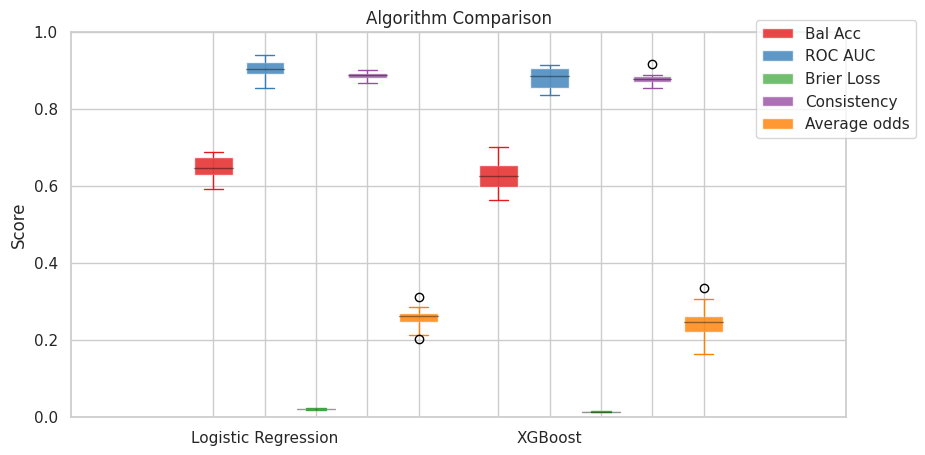

In [39]:
threshold_models = {
    "Logistic Regression" : threshold_tuner.best_model,
    "XGBoost"             : xgb_threshold_tuner.best_model
}

results = evaluate(threshold_models, X_train, y_train, X_test, y_test, metrics=metrics, cv=10, df=results, configs={"Fairness method" : "Threshold Optimization"}, figname="Threshold optimization comparison")
style(results, format_table)

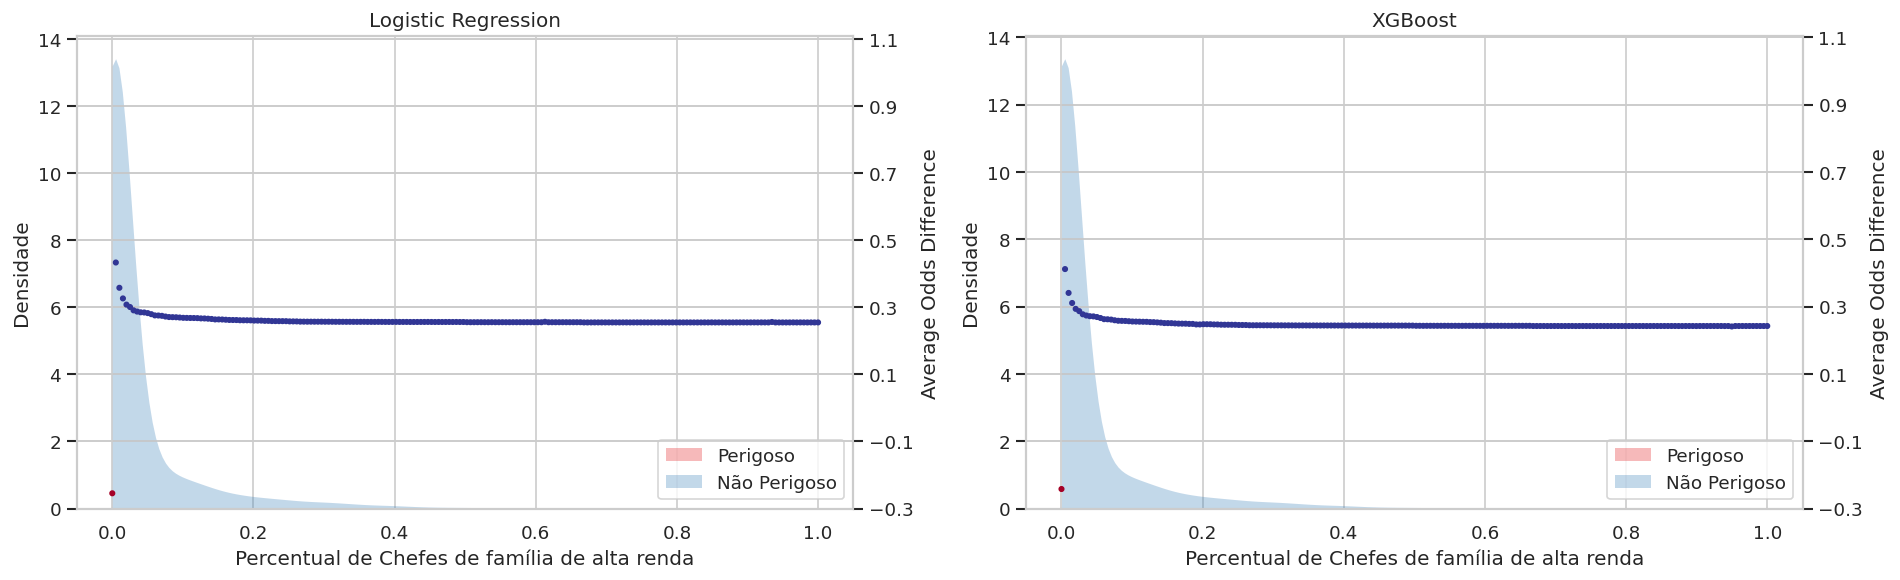

In [41]:
plot_sensitive(threshold_models, X_train, y_train, "CAR10", n=200, figname="Threshold optimization sensitive")

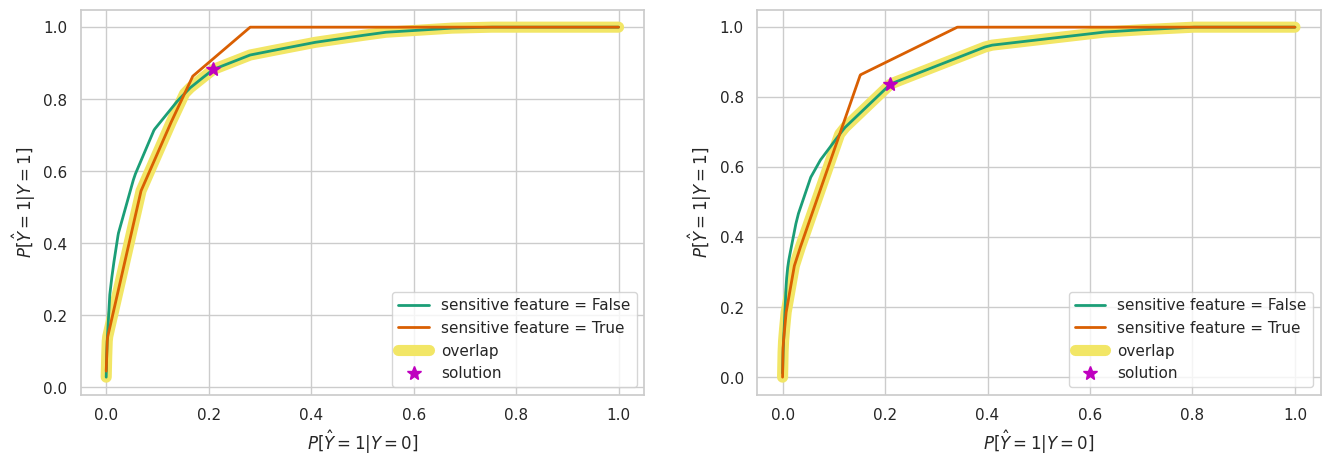

In [42]:
from fairlearn.postprocessing import plot_threshold_optimizer

fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

plot_threshold_optimizer(threshold_model, ax=axs[0], show_plot=False)
plot_threshold_optimizer(xgb_threshold_model, ax=axs[1], show_plot=False)

plt.savefig("Threshold optimization roc")

plt.show()

#### Another Post-processing

In [89]:
from sklego.meta import ConfusionBalancer

In [100]:
logistic_pipeline = Pipeline([('transform', MinMaxScaler()), ('model', LogisticRegression())])

balanced_logistic_model    = ConfusionBalancer(logistic_pipeline)

balanced_logistic_tuner = Optuner(balanced_logistic_model, X_train, y_train, scoring="balanced_accuracy", seed=42)

balanced_logistic_tuner.add_parameter('estimator__model__penalty', 'categorical', choices=['l1', 'l2'])
balanced_logistic_tuner.add_parameter('estimator__model__C', float, low=1e-5, high=1e4, log=True)
balanced_logistic_tuner.fix_parameter('estimator__model__solver', 'liblinear')
balanced_logistic_tuner.add_float('alpha', 0, 1)

balanced_logistic_tuner.optimize(n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

In [102]:
xgb_balanced_tuner = Optuner(ConfusionBalancer(XGBClassifier()), X_train, y_train, scoring="balanced_accuracy", seed=42)

xgb_balanced_tuner.add_categorical('estimator__max_depth', [2, 4, 5, 6, 8])
xgb_balanced_tuner.add_float('estimator__learning_rate', low=1e-2, high=1e-1, log=True)
xgb_balanced_tuner.add_int('estimator__n_estimators', low=50, high=200)
xgb_balanced_tuner.add_float('estimator__subsample', low=0.5, high=1)

xgb_balanced_tuner.optimize(n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

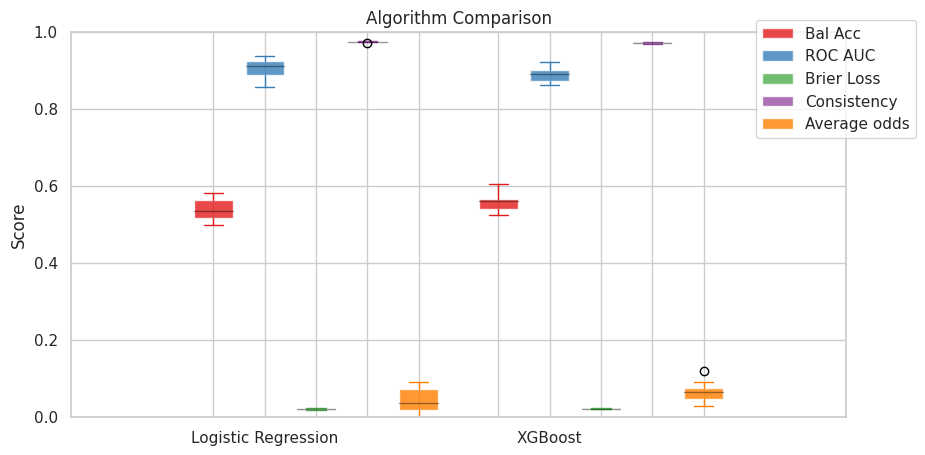

In [103]:
balanced_models = {
    "Logistic Regression" : balanced_logistic_tuner.best_model,
    "XGBoost"             : xgb_balanced_tuner.best_model
}

results = evaluate(balanced_models, X_train, y_train, X_test, y_test, metrics=metrics, cv=10, df=results, configs={"Fairness method" : "Confusion Balance"}, figname="Confusion balance comparison")
style(results, format_table)

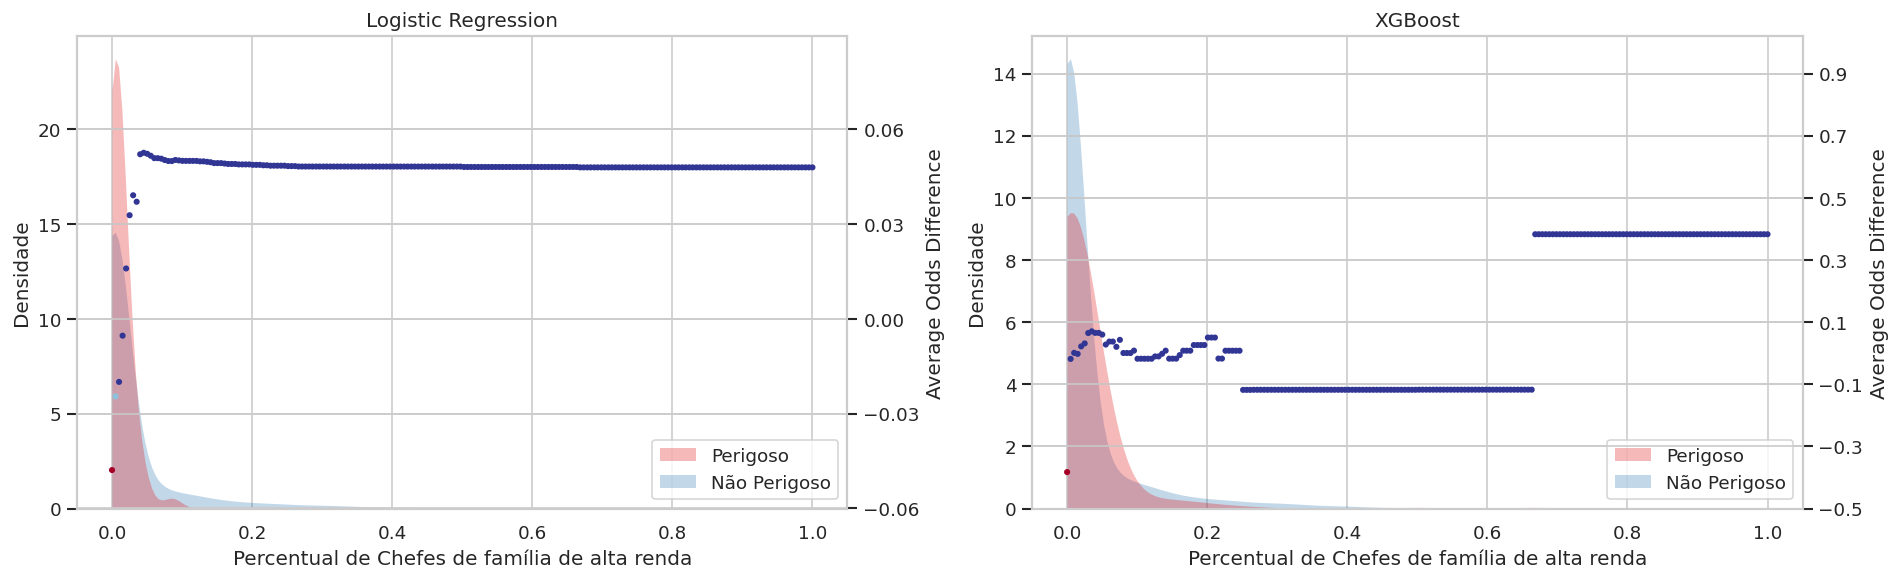

In [104]:
plot_sensitive(balanced_models, X_train, y_train, "CAR10", n=200, figname="Confusion balance sensitive")

In [116]:
order = {
    "None" : 0,
    "Data Augmentation" : 1,
    "Fair representations" : 2,
    "Equal Opportunity" : 3,
    "Threshold Optimization" : 4,
    "Confusion Balance" : 5
}

In [132]:
style(results.loc[(["Logistic Regression", "XGBoost"], )], format_table)

In [145]:
(results["Average odds"] - results["Average odds"].mean())/results['Average odds'].std()

Model                Fairness method       
Logistic Regression  None                     -0.558577
XGBoost              None                     -0.334309
Logistic Regression  Data Augmentation        -0.240887
XGBoost              Data Augmentation        -0.350916
Logistic Regression  Fair representations     -0.858888
XGBoost              Fair representations     -0.739831
Logistic Regression  Equal Opportunity         0.070605
                     Threshold Optimization    2.022362
XGBoost              Threshold Optimization    1.893293
Logistic Regression  Confusion Balance        -0.558577
XGBoost              Confusion Balance        -0.344273
Name: Average odds, dtype: object